In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import spaces

import numpy as np

from embodiment_distance import cost
from robot_model import Model
from states_from_json import mapping



class HumanArmImitation(gym.Env):
    """ RL agent environment for human arm imitation.
        
    """
    metadata = {'render.modes': ['console']}

    def __init__(self, path):
        super(HumanArmImitation, self).__init__()

        # based on the path to the json files, 
        # returns real positions, thetas ,dthetas and L_list
        self.real_poses, self.thetas, self.dthetas, self.L_list = mapping(path,dt=0.1)
        
        #30 frames/s, so take every 3 states from teacher
        self._next = 0
        self.inc = 3 #increment unit
        self.next_limit = self.thetas.shape[0]/self.inc
        
        self.weights = np.array([1.0, 1.0, 1, 1])#[0.0, 1.0, 0.001, 0.01]

        # Define action and observation space
        # They must be gym.spaces objects
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(6,))
        self.observation_space = spaces.Box(low=-62.56794665922222,high=61.59437215133977,shape=(2,2,6))

    def reset(self, initial_random=False):
        """ initialize state to starting position
            returns initial state
        """
        # restart counter
        self._next = 0
        # get initial teacher state
        initial_teacher = self.thetas[self._next], self.dthetas[self._next]

        # initial learner start state
        if initial_random:
            # start learner at random initial_state
            ranth, randth = self.observation_space.sample()
            initial_learner = ranth[0], randth[0]
        else:
            # start learner at same initial state as teacher
            initial_learner = initial_teacher

        self.state = np.array([initial_teacher, initial_learner])
        return self.state

    def is_terminal(self):
        return self._next >= self.next_limit

    @property
    def next(self):
        return self._next
    
    def step(self, u, print_log=False):
        """ given an action
            takes a step in the environment
            returns next state, reward, is_terminal, {}
        """
        # given action
        taumat = [u]

        # get current state
        # increment teacher traj
        self._next += self.inc

        teacher_st, learner_st = self.state  #

        # use embodiment_distance cost to compute cost of state
        c = cost(teacher_st[0], 
            teacher_st[1], 
            self.L_list, 
            learner_st[0], 
            learner_st[1], 
            self.L_list, 
            self.weights)

        # use robot_model to compute learner's next states
        next_thetas, next_dthetas = Model(learner_st[0], learner_st[1], taumat, self.L_list)

        # update learner's component of next state
        learner_stnext = next_thetas[0], next_dthetas[0]
        #print(f"learner_stnext: {learner_stnext}")

        # fetch teacher's component of next state
        teacher_stnext = self.thetas[self.next], self.dthetas[self.next]
        #print(f"teacher_stnext: {teacher_stnext}")

        # update state
        self.state = np.array([teacher_stnext, learner_stnext])
        assert self.state.shape == self.reset().shape
        
        if print_log:
            print(f"State.shape: {self.state.shape}, Reward: {-c*10000}, Done: {self.is_terminal()}")

        # return next state, -cost, is_terminal, extra
        return self.state, -c*10000, self.is_terminal(), {}

    def render(self, mode='console'):
        if mode != 'console':
            raise NotImplementedError()

    def close(self):
        pass

In [2]:
poses, tas, dtas, L_l = mapping('c2fixc',dt=0.1)

(6,)
(828, 7, 2)
(828, 2)


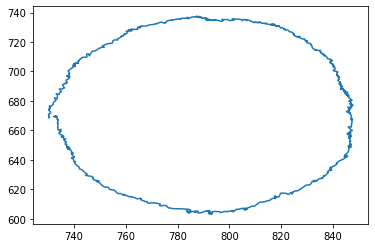

In [10]:

print(np.shape(tas[0]))
pth=[]
for i in range(len(tas)):
    pth.append(position_from_angle(tas[i],L_l,[500,500]))
pth=np.array(pth)
print(np.shape(pth))
pp=pth[:,6,:]
print(np.shape(pp))
plt.plot(pp[:,0],pp[:,1])

In [4]:
# instantiate our environment class
env = HumanArmImitation('c2fixc')

In [5]:
# get initial state data
s = env.reset()
# assign to teacher t, learner l
t, l = s

In [6]:
thetas, dthetas = t
links = env.L_list

In [7]:
thetas

array([ 2.67794504, -2.21429744, -0.21405321,  0.69750337, -2.03251882,
        0.09931857])

In [8]:
dthetas

array([ 0.06112607,  0.01557405, -0.12896018,  0.05368697,  0.10342265,
       -0.22417373])

In [9]:
# teacher thetas and dthetas for complete trajectory
th = env.thetas
dth = env.dthetas

In [10]:
# xylist = []
# for i in range(len(th)):
#     x = 0 + links[5] * np.cos(th[i][5])
#     y = 0 + links[5] * np.sin(dth[i][5])
#     xylist.append((x,y))
#     #print(f"len: {links[5]}, coord: ({x},{y})")

def get_xylist(theta,dtheta,linkers,linknum=5,anglenum=5):
    xylist = []
    for i in range(len(theta)):
        x = 0 + linkers[linknum] * np.cos(theta[i][anglenum])
        y = 0 + linkers[linknum] * np.sin(dtheta[i][anglenum])
        xylist.append((x,y))
        #print(f"len: {links[5]}, coord: ({x},{y})")
    return xylist

In [11]:
# create a dict of 828 keys, each with
teacher_poses = {}

for i in range(len(env.real_poses)):
    teacher_poses[i] = [tuple(env.real_poses[j][4]) for j in range(env.real_poses.shape[0])]


In [13]:
def plot_positions( somebodys_poses ):
    # given a dict of joint positions
    
    # create figure
    fig = plt.figure('Real poses', figsize=(12, 8))
    # create axes
    ax_pos = fig.add_subplot(111)
    
    # for each joint: position
    for key in somebodys_poses.keys():
        
        tf = np.array([(i[0],i[1]) for i in somebodys_poses[key]]).T
        plt.plot(tf[0],tf[1])


    ax_pos.invert_yaxis()

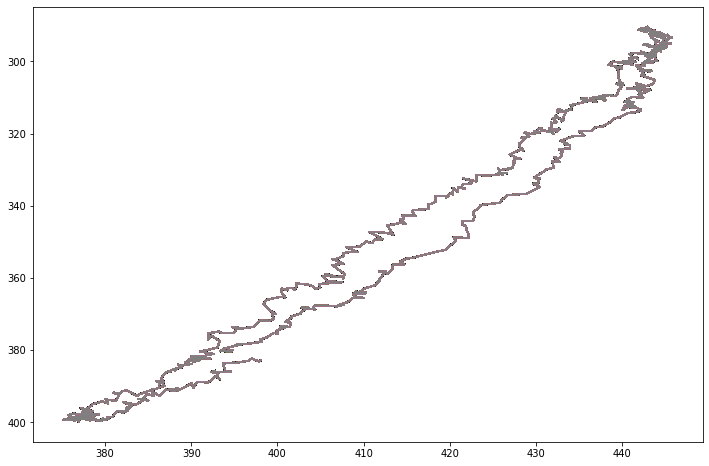

In [14]:
plot_positions(teacher_poses)

In [18]:
def position_from_angle(thetas,L_list,base_pose,link_idx,th_index):#
    
    # base_pose default (0,0)
    x_old, y_old = base_pose

    poses=[]
    for i in range(len(thetas)):
        
        x = L_list[link_num] * np.cos( thetas[i][th_num] )
        y = L_list[link_num] * np.sin( thetas[i][th_num] )

        poses.append([x,y])

    return poses

def plot_pose(p):
    pp = np.array([(i[0],i[1]) for i in p]).T
    plt.plot(pp[0],pp[1])

In [19]:
for i in range(6):
    for j in range(6):
        p=position_from_angle(th,links,i,j)
        plot_pose(p)

TypeError: position_from_angle() missing 1 required positional argument: 'th_index'

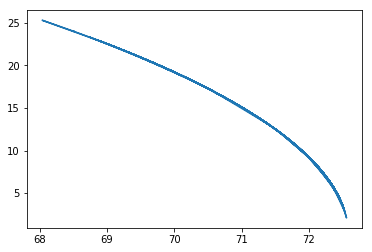

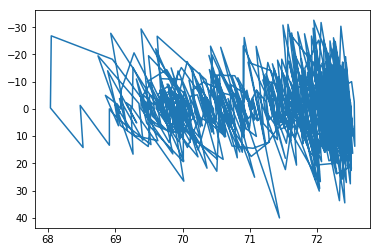

In [57]:
plot_positions(xy)

In [9]:
print(f"Loading environment")
env = HumanArmImitation('c2fixc')
obs = env.reset()
n_steps = 10
for _ in range(n_steps):
  # Random action
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action,print_log=False)
  
  env.plot_teacher()
    
  if done:
          obs = env.reset()

Loading environment
plot
plot
plot
plot
plot
plot
plot
plot
plot
plot
